In [28]:
import altair as alt

from src.data.read_dataset import get_processed_dataset
from src.visualization import visualize

In [29]:
df = get_processed_dataset('ECDC')

In [30]:
df['casesPerPop'] = df.TotalCases / df.popData2018 * 1e6
df['deathsPerPop'] = df.TotalDeaths / df.popData2018 * 1e6
df.tail()

,dateRep,day,month,year,cases,deaths,Country,geoId,countryterritoryCode,popData2018,TotalCases,TotalDeaths,casesPerPop,deathsPerPop
7315,2020-03-25,25,3,2020,0,0,Zimbabwe,ZW,ZWE,14439018.0,2,1,0.138514,0.069257
7316,2020-03-24,24,3,2020,0,1,Zimbabwe,ZW,ZWE,14439018.0,2,1,0.138514,0.069257
7317,2020-03-23,23,3,2020,0,0,Zimbabwe,ZW,ZWE,14439018.0,2,0,0.138514,0.000000
7318,2020-03-22,22,3,2020,1,0,Zimbabwe,ZW,ZWE,14439018.0,2,0,0.138514,0.000000
7319,2020-03-21,21,3,2020,1,0,Zimbabwe,ZW,ZWE,14439018.0,1,0,0.069257,0.000000


## Number of confirmed cases in selected countries
This plot shows the number of total confirmed cases over time. Note that the y-axis is logarithmic since the progression can be approximated with an exponential function (at least at the beginning of the outbreak). The plot includes selected EU countries and South Korea, which records the largest number of cases worldwide after China.

In [31]:
alt.themes.enable('theme_1')
countries = ['Italy', 'Austria', 'France', 'Spain', 'Germany', 'Switzerland', 'South Korea', 'United States of America']
from altair import datum

alt.Chart(df[(df.Country.isin(countries)) & (df.dateRep > '2020-02-21')]).mark_line().encode(
    alt.Y('TotalCases', scale=alt.Scale(type='log')),
    alt.X('dateRep:T', axis = alt.Axis(title = 'Date', format = ("%d.%m"))),
    color='Country',
    tooltip=['Country', 'dateRep', 'TotalCases']
).properties(
    height=600,
    width=800
).transform_filter(
    (datum.TotalCases > 10)
).interactive()

alt.Chart(...)

In [32]:
alt.Chart(df[(df.Country.isin(countries)) & (df.dateRep > '2020-02-21')]).mark_line().encode(
    alt.Y('casesPerPop', scale=alt.Scale(type='log')),
    alt.X('dateRep:T', axis = alt.Axis(title = 'Date', format = ("%d.%m"))),
    color='Country',
    tooltip=['Country', 'dateRep', 'casesPerPop']
).properties(
    height=600,
    width=800
).transform_filter(
    (datum.TotalCases > 10)
).interactive()

alt.Chart(...)

## Number of deaths in selected countries
This plot shows the number of deaths over time in the same countries reported above.

In [33]:
alt.themes.enable('theme_1')
from altair import datum

alt.Chart(df[(df.Country.isin(countries)) & (df.dateRep>'2020-02-21')]).mark_line().encode(
    alt.Y('TotalDeaths', scale=alt.Scale(type='log')),
    alt.X('dateRep:T', axis = alt.Axis(title = 'Date', format = ("%d.%m"))),
    color='Country',
    tooltip=['Country', 'dateRep', 'TotalDeaths']
).properties(
    height=600,
    width=800
).transform_filter(
    (datum.TotalDeaths > 0)
).interactive()

alt.Chart(...)

In [34]:
alt.Chart(df[(df.Country.isin(countries)) & (df.dateRep>'2020-02-21')]).mark_line().encode(
    alt.Y('deathsPerPop', scale=alt.Scale(type='log')),
    alt.X('dateRep:T', axis = alt.Axis(title = 'Date', format = ("%d.%m"))),
    color='Country',
    tooltip=['Country', 'dateRep', 'deathsPerPop']
).properties(
    height=600,
    width=800
).transform_filter(
    (datum.TotalDeaths > 0)
).interactive()

alt.Chart(...)

In [35]:
from scipy.optimize import curve_fit
from tabulate import tabulate
from IPython.display import HTML
import numpy as np
import pandas as pd

countries = countries + ['Netherlands', 'Sweden', 'Norway', 'Finland', 'Belgium', 'United Kingdom', 'Australia']

fits = []
for country in countries:
    country_df = df[(df.Country == country) & (df.TotalCases>50)]
    ydata = country_df.TotalCases[::-1]
    xdata = np.arange(len(ydata))
    try:
        popt, pcov = curve_fit(f=lambda t,a,b: a*2**(t/b),xdata=xdata,ydata=ydata)
        if popt[1] > 0:
            fits.append([country, popt[1]])
    except:
        continue
        
cdf = pd.DataFrame(fits, columns=['Country', 'Doubling Rate']).set_index('Country').sort_values('Doubling Rate')
HTML(cdf.to_html(float_format=lambda x: '%10.2f' % x))

,Doubling Rate
Country,
United States of America,2.91
United Kingdom,3.60
Australia,3.67
Spain,3.91
Belgium,3.99
Austria,4.01
Germany,4.05
Netherlands,4.29
France,4.58


Text(0, 13000, 'Confirmed COVID-19 cases since start of the epidemic')

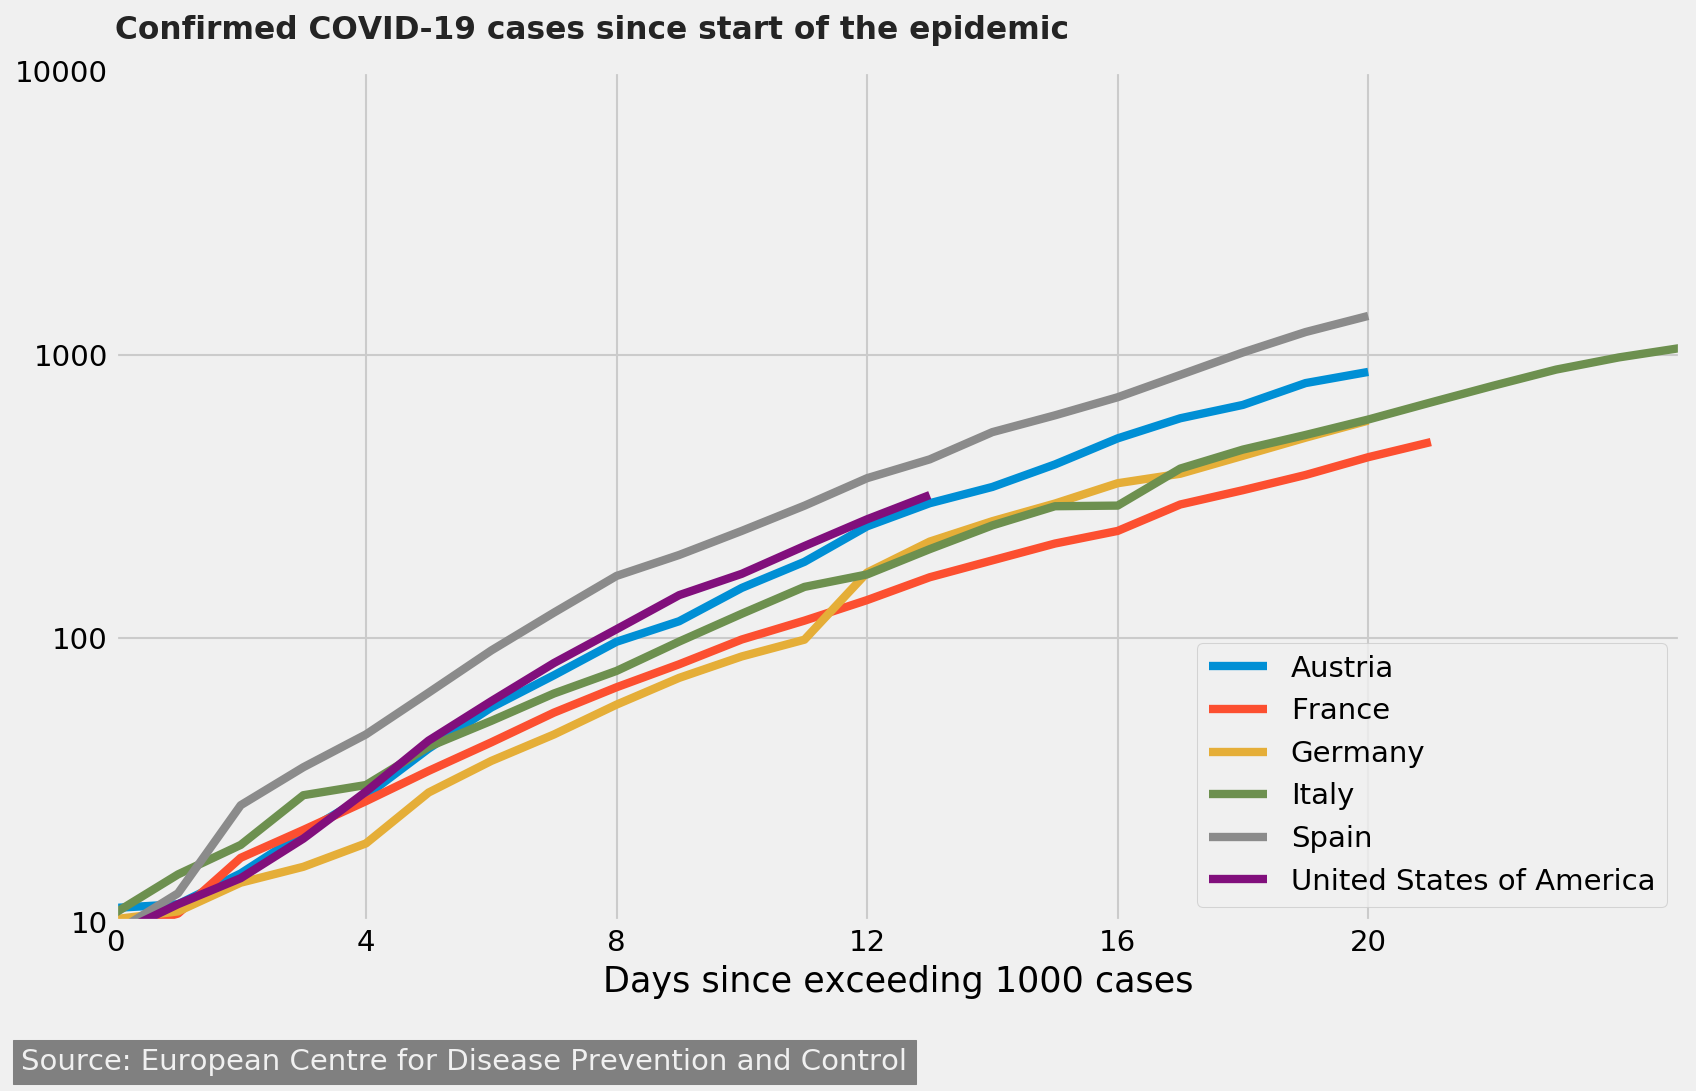

In [46]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
plt.style.use('fivethirtyeight')

fig, ax = plt.subplots(figsize=(12,7))
countries = ['Italy', 'France', 'Spain', 'Germany', 'United States of America', 'Austria']

for g, n in df[df.casesPerPop > 9].iloc[::-1].groupby('Country')['casesPerPop']:
    if g in countries:
        xrange = range(len(n))
        ax.semilogy(xrange, n, label=g)

ymin = 0
ax.legend(loc='lower right')
ax.tick_params(axis = 'both', which = 'major', labelsize = 14)
ax.set_xlabel('Days since exceeding 1000 cases')
ax.set_xticks(range(0, 21, 4))
ax.set_xlim([0, 25])
ax.set_ylim([10, 10000])
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.axhline(y = ymin, color = 'black', linewidth = 10, alpha = .7)
ax.text(x = -1.5, y = 3,
    s = 'Source: European Centre for Disease Prevention and Control', fontsize = 14, color = '#f0f0f0', backgroundcolor = 'grey')
ax.text(x = 0, y = 13000,
               s = 'Confirmed COVID-19 cases since start of the epidemic',
              fontsize = 15, alpha = .85, weight = 'bold')